# Implementing a GAMLSS normative model for cortical thickness

---

### package imports and basic functions

---

In [1]:
import os
import gc
import sys
import glob
import json
import random
import datetime
import importlib
import itertools
import numpy as np
from scipy import spatial
import scipy.sparse as sparse
import scipy.stats as stats
import pandas as pd
import nibabel as nib
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import boto3


In [2]:
# for gamlss we need R through rpy2

# for magic R command
%load_ext rpy2.ipython

# R related imports
import rpy2
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter
from rpy2.robjects import Formula
from rpy2.robjects.lib import grdevices
from rpy2.robjects import numpy2ri
numpy2ri.activate()


# import R's "base" package
base = importr('base')

# import R's "utils" package
rutils = importr('utils')

# import any other required packages
gamlss = importr('gamlss')
# library(ggpointdensity)
# library(cowplot)
# library(patchwork)
# library(qqplotr)
# library(R.matlab)
# library(Hmisc)
# library(rstatix)
# library(ggpubr)
# library(scoring)

# to handle appropriate plots
import IPython


In [3]:
class MyNumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return super(MyEncoder, self).default(obj)


def ensure_dir(file_name):
    os.makedirs(os.path.dirname(file_name), exist_ok=True)
    return file_name


def list_dirs(path=os.getcwd()):
    files = glob.glob(os.path.join(path, '*'))
    files = [x for x in files if os.path.isdir(x)]
    return files


def file_exists(file_name, path_name=os.getcwd()):
    return os.path.isfile(os.path.join(path_name, file_name))


def write_json(json_obj, file_path):
    with open(file_path, 'w') as outfile:
        json.dump(json_obj, outfile, sort_keys=True, indent=4,
                  cls=MyNumpyEncoder)
    return json_obj


def load_json(file_path):
    with open(file_path, 'r') as infile:
        return json.load(infile)


def write_np(np_obj, file_path):
    with open(file_path, 'wb') as outfile:
        np.save(outfile, np_obj)


def load_np(file_path):
    with open(file_path, 'rb') as infile:
        return np.load(infile)


In [4]:
# path setting
main_dir = os.path.abspath('../../../..')


## Load aggregated data

---

In [5]:
demography_df = pd.read_csv(f'{main_dir}/data/csv/demography_all_datasets.csv', index_col=0)


## Fit GAMLSS with sex and site covariates

---

In [6]:
%%time
%%R

mainDir <- normalizePath('../../../..')

dataSample <- read.csv(paste(mainDir,'/data/csv/demography_all_datasets.csv', sep=""))

model <- gamlss(
    thickness~fp(age) + sex + random(as.factor(siteCode)),
    sigma.formula=~fp(age) + sex + random(as.factor(siteCode)),
    nu.formula=~fp(age),
    tau.formula=~fp(age),
    data=dataSample,
    family=BCPE,
)

save(model, file=paste(mainDir,'/data/models/gamlss/mean_thickness.rda', sep=""))


GAMLSS-RS iteration 1: Global Deviance = -4755.383 
GAMLSS-RS iteration 2: Global Deviance = -4939.879 
GAMLSS-RS iteration 3: Global Deviance = -4943.176 
GAMLSS-RS iteration 4: Global Deviance = -4943.261 
GAMLSS-RS iteration 5: Global Deviance = -4943.256 
GAMLSS-RS iteration 6: Global Deviance = -4943.26 
GAMLSS-RS iteration 7: Global Deviance = -4943.26 
CPU times: user 8.5 s, sys: 10.3 ms, total: 8.51 s
Wall time: 8.5 s


new prediction 
New way of prediction in random()  (starting from GAMLSS version 5.0-6) 
new prediction 
New way of prediction in random()  (starting from GAMLSS version 5.0-6) 
new prediction 
new prediction 
new prediction 
New way of prediction in random()  (starting from GAMLSS version 5.0-6) 
new prediction 
New way of prediction in random()  (starting from GAMLSS version 5.0-6) 
new prediction 
new prediction 
new prediction 
New way of prediction in random()  (starting from GAMLSS version 5.0-6) 
new prediction 
New way of prediction in random()  (starting from GAMLSS version 5.0-6) 
new prediction 
new prediction 
new prediction 
New way of prediction in random()  (starting from GAMLSS version 5.0-6) 
new prediction 
New way of prediction in random()  (starting from GAMLSS version 5.0-6) 
new prediction 
new prediction 
new prediction 
New way of prediction in random()  (starting from GAMLSS version 5.0-6) 
new prediction 
New way of prediction in random()  (starting from GAMLS

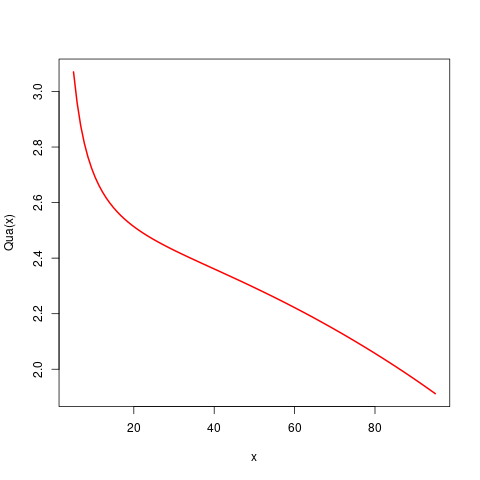

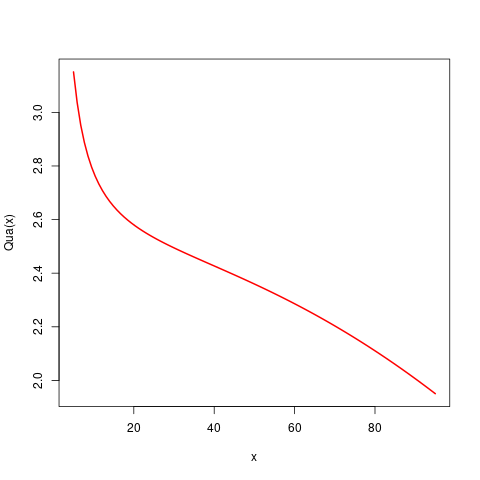

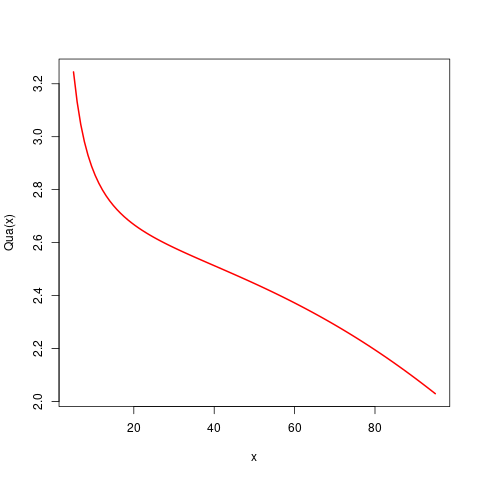

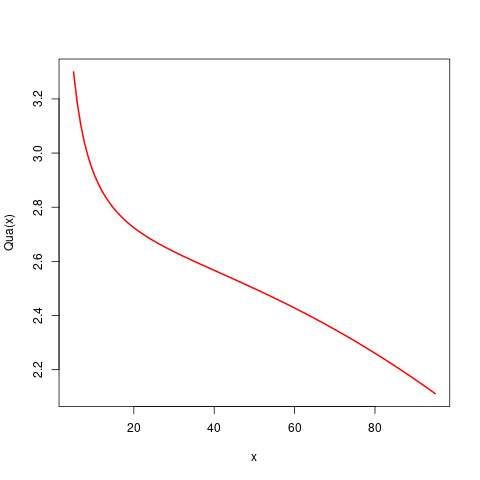

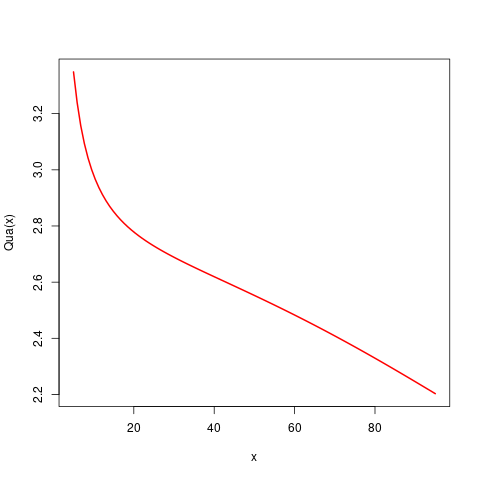

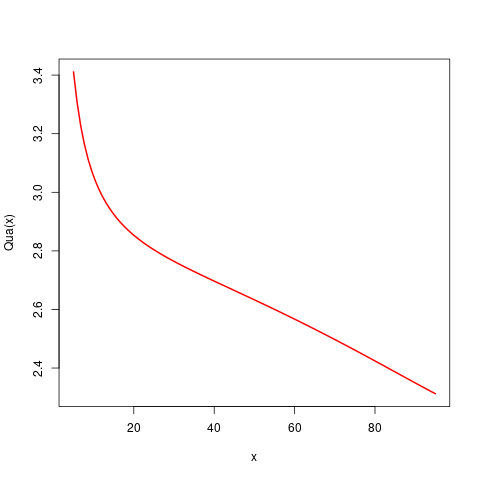

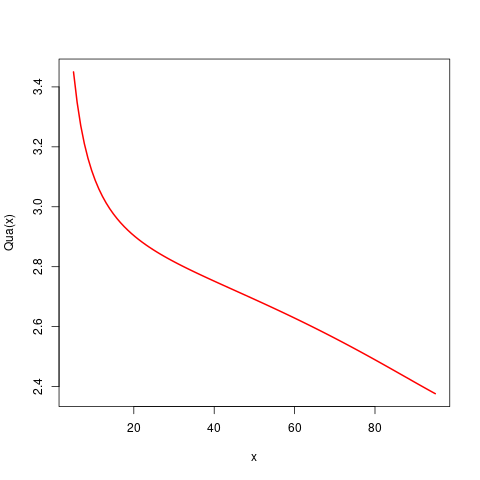

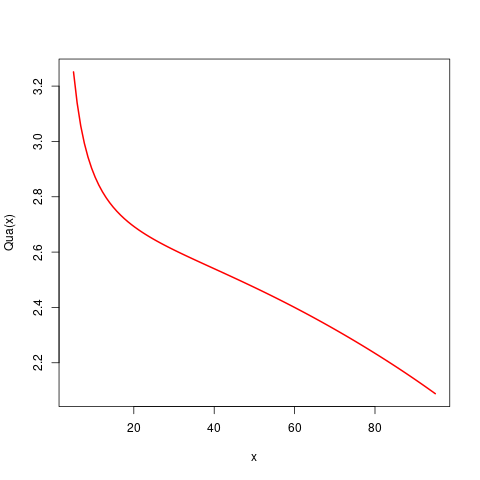

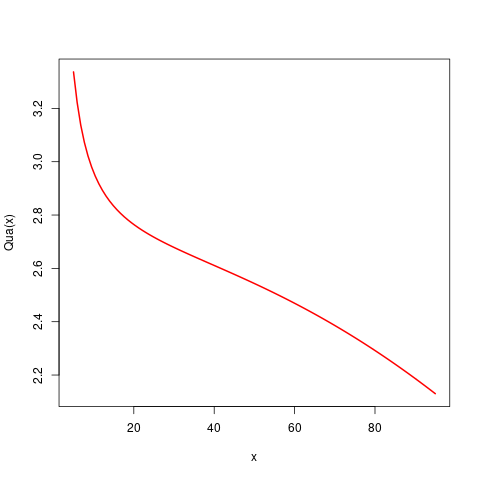

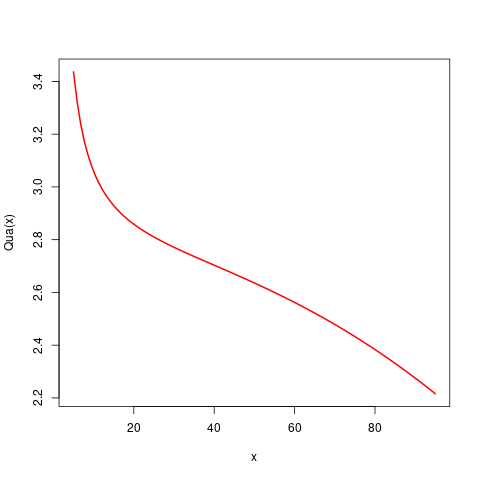

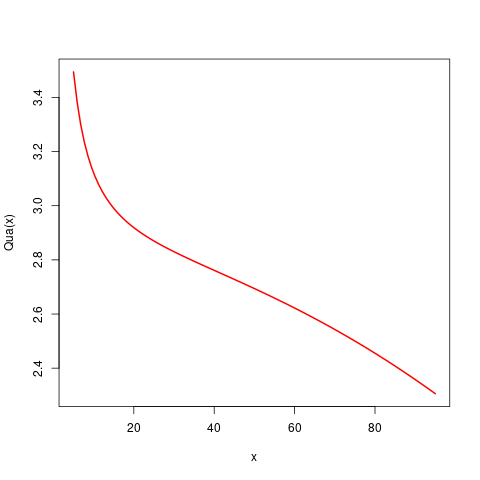

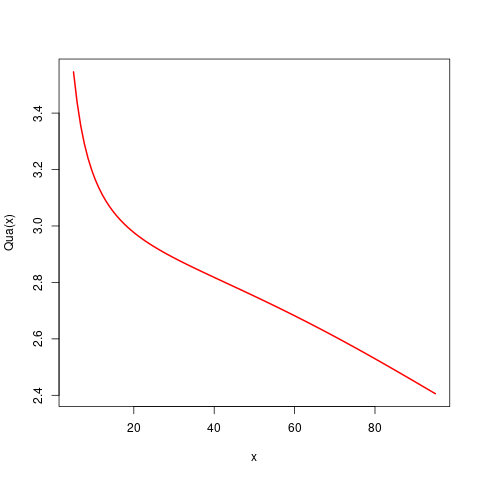

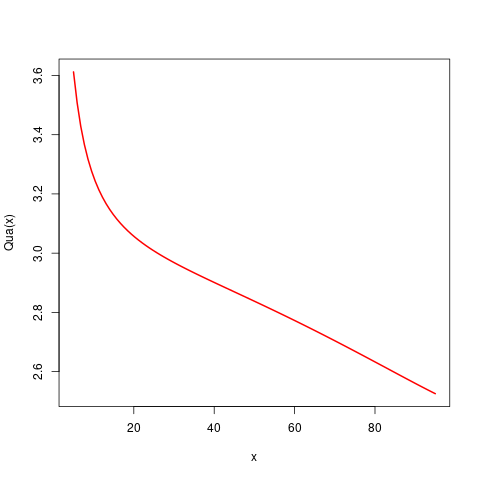

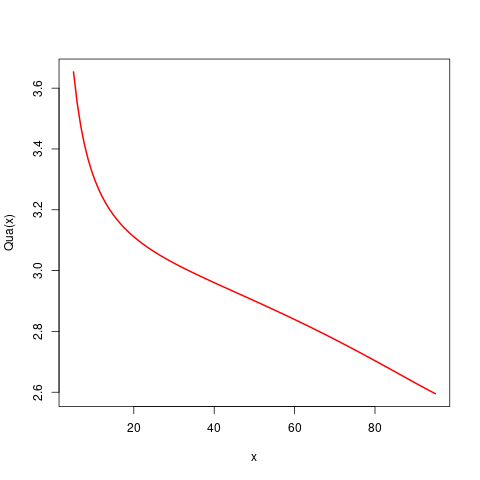

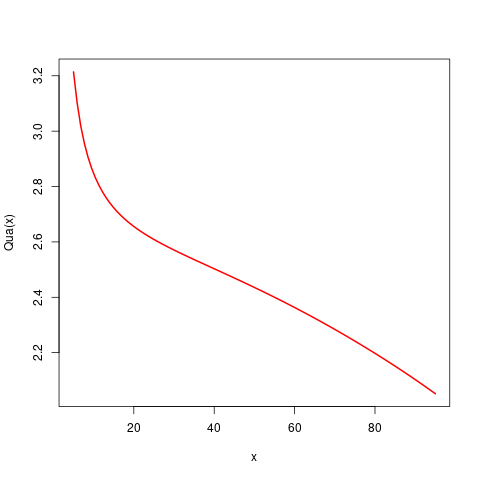

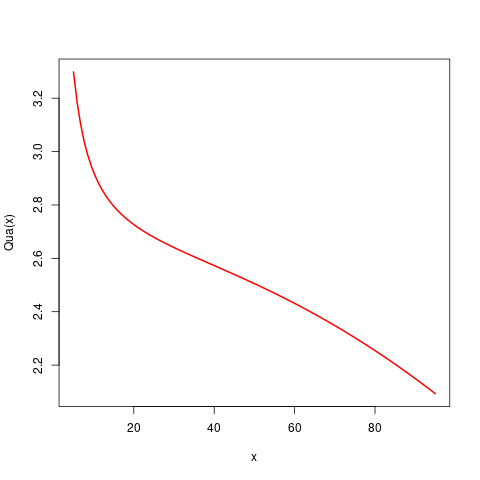

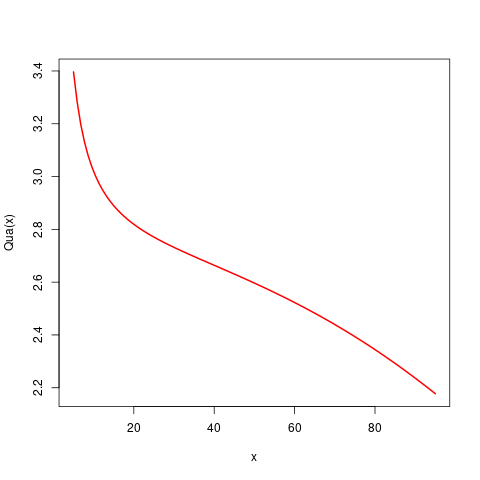

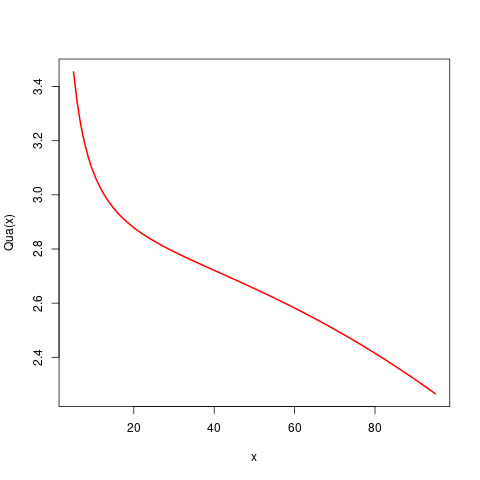

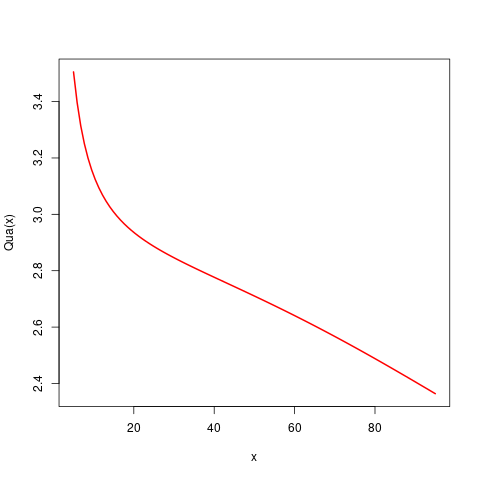

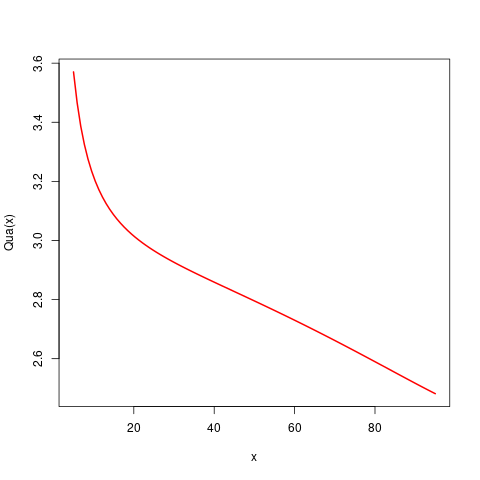

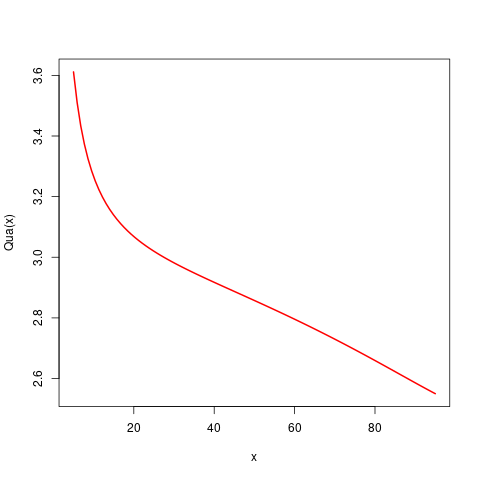

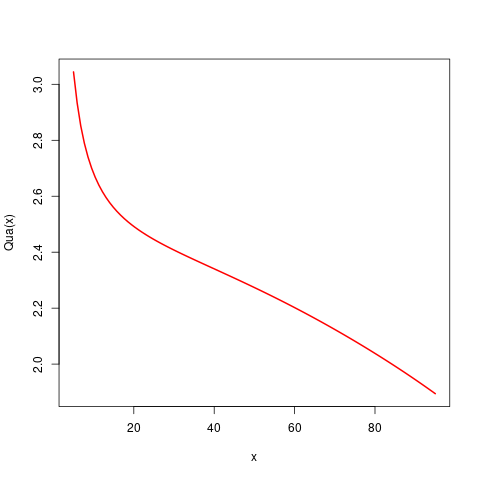

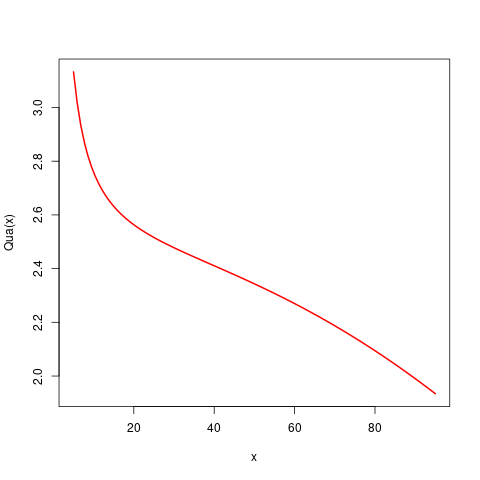

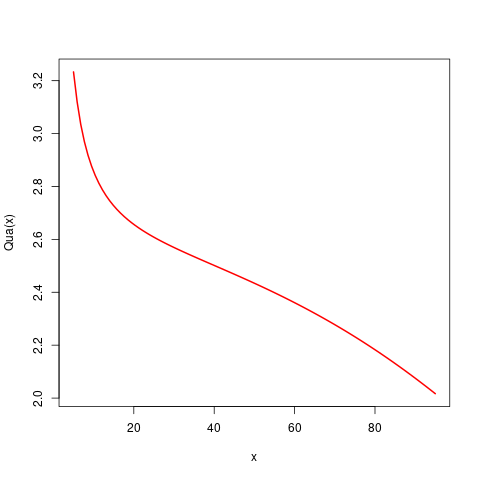

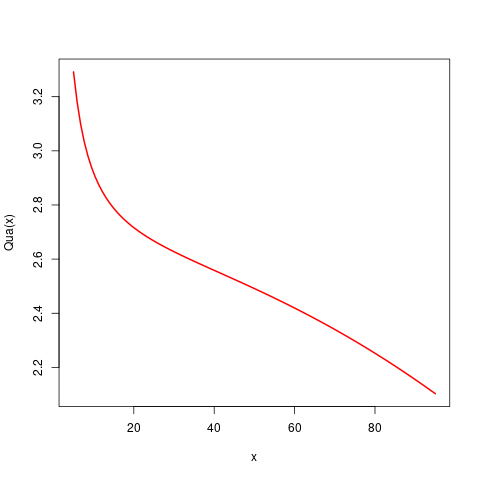

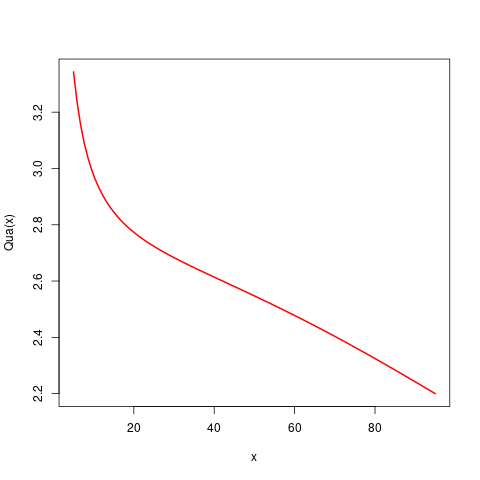

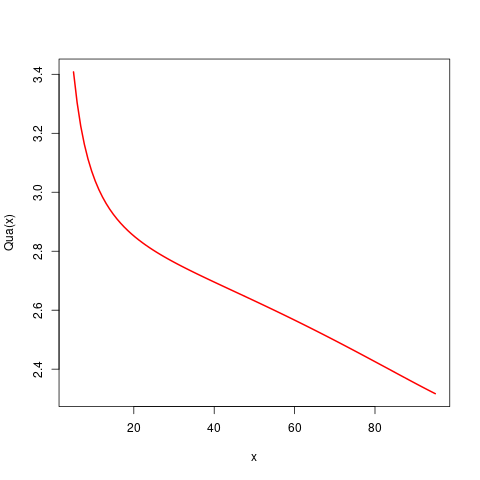

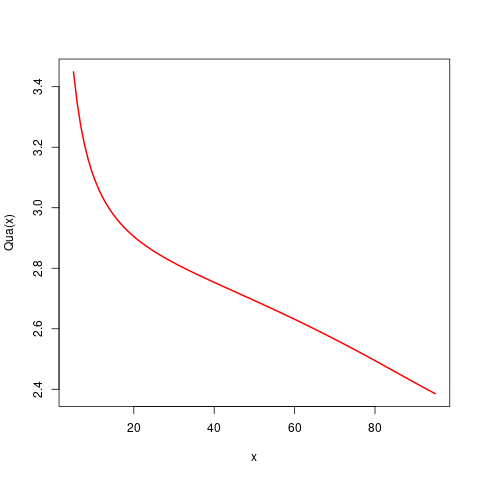

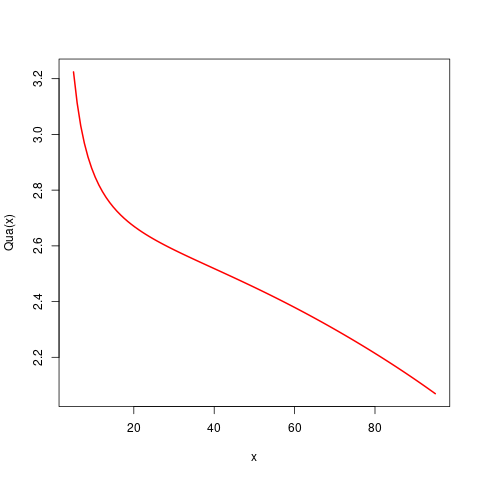

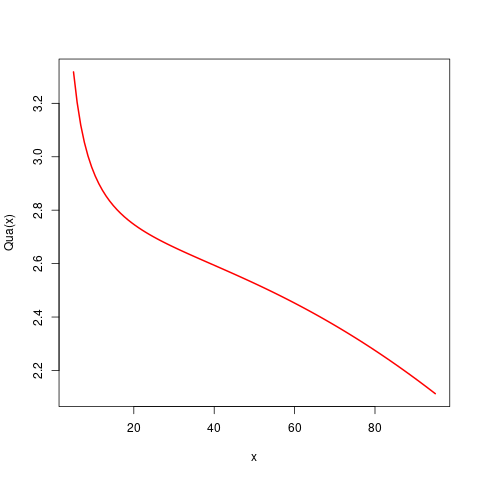

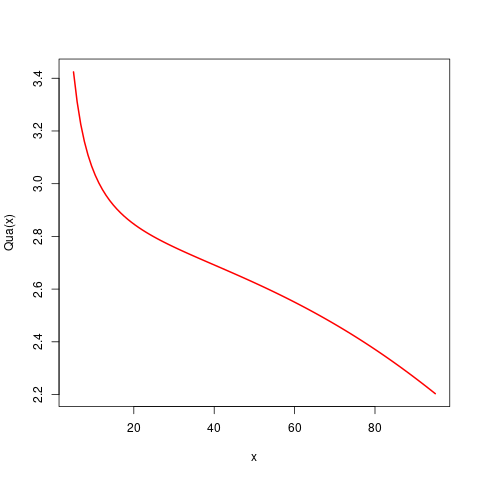

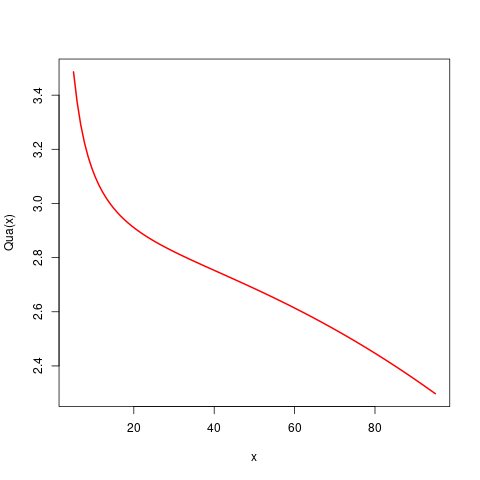

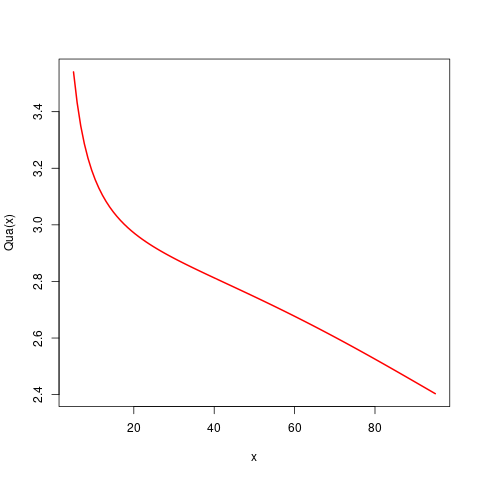

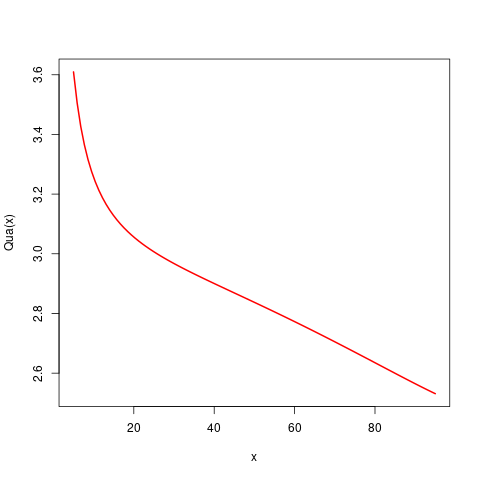

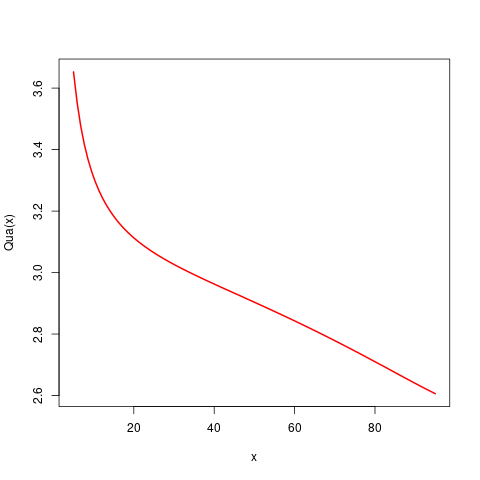

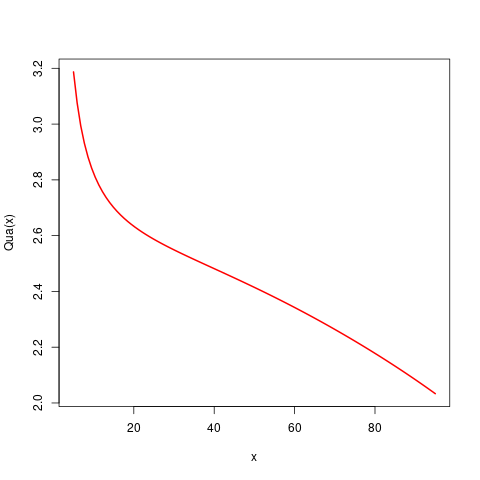

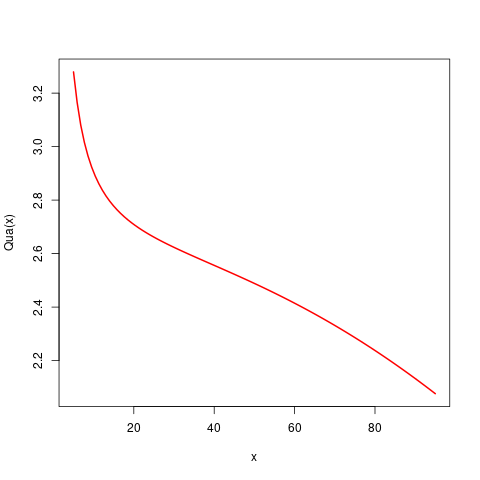

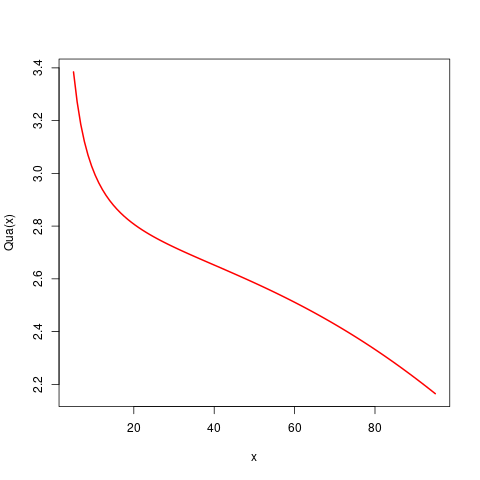

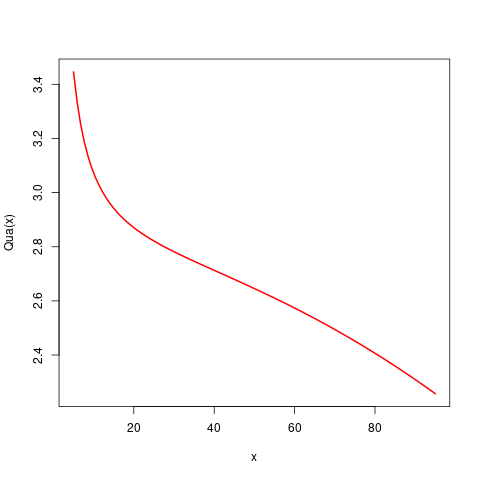

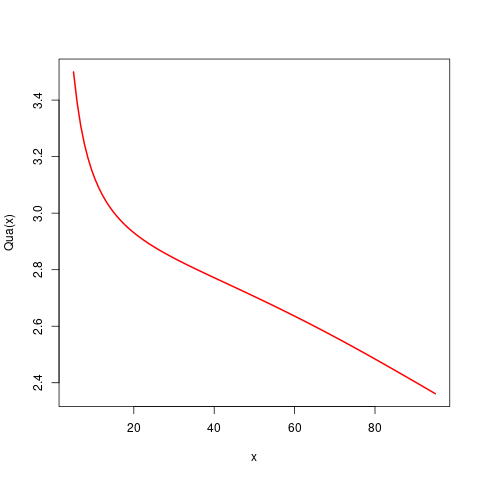

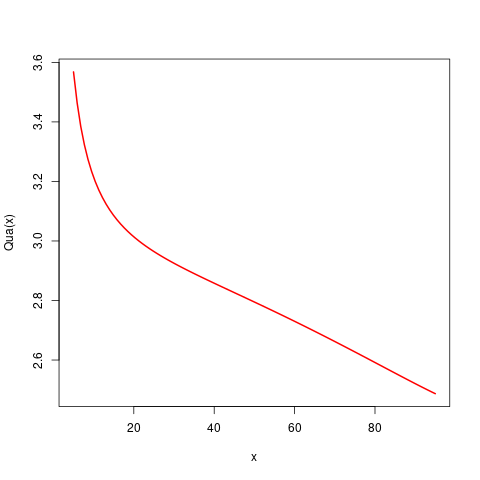

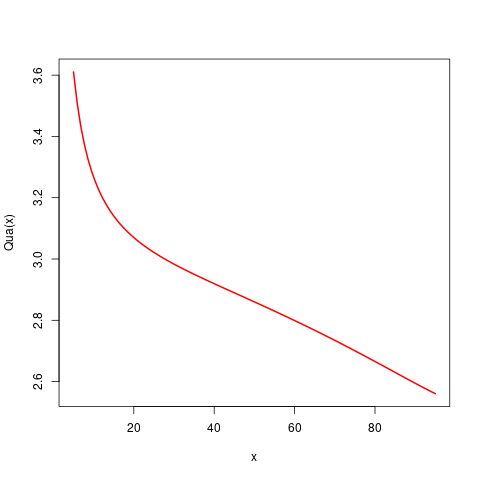

CPU times: user 7.49 s, sys: 148 ms, total: 7.64 s
Wall time: 7.39 s


In [7]:
%%time
%%R

mainDir <- normalizePath('../../../..')

load(paste(mainDir,'/data/models/gamlss/mean_thickness.rda', sep=""))

quantiles<-c(.01, .05, 0.25, 0.5, 0.75, 0.95, .99)
sites<-unique(dataSample$siteCode)
sexes<-unique(dataSample$sex)

x<-matrix(data=NA,ncol=length(quantiles),nrow=101)
y<-matrix(data=NA,ncol=length(quantiles),nrow=101)

for (k in 1:length(sexes)){
    for (j in 1:length(sites)){
        for (i in 1:length(quantiles)){

            Qua <- getQuantile(
                model,
                quantile=quantiles[i],
                term='age',
                fixed.at=list(siteCode=sites[j], sex=sexes[k]),
            )

            c <- curve(Qua, 5, 95,  lwd=2, lty=1, add=quantiles[i], col="red")

            x[,i]<-c$x
            y[,i]<-c$y
        }
        write.matrix(x,paste(mainDir,'/data/tmp/gamlss/quantiles_model_x_site_',sites[j],'_sex_',sexes[k],'.csv',sep=""))
        write.matrix(y,paste(mainDir,'/data/tmp/gamlss/quantiles_model_y_site_',sites[j],'_sex_',sexes[k],'.csv',sep=""))
    }
}


## Visualise fitted centiles

---

CPU times: user 480 ms, sys: 374 ms, total: 854 ms
Wall time: 95.8 ms


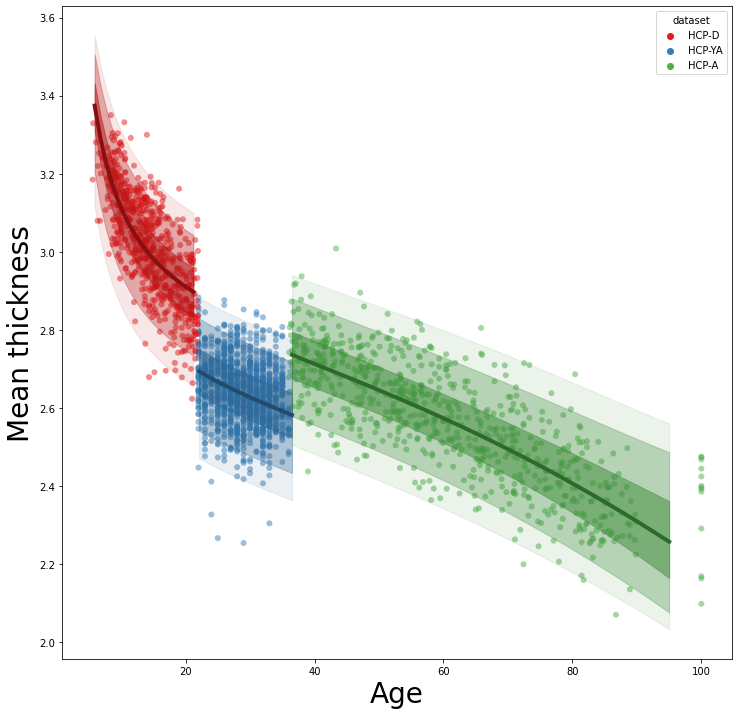

In [8]:
%%time

fig, ax = plt.subplots(1, 1, figsize=(12, 12))

data_order = demography_df.groupby(by=["dataset"])["age"].median().sort_values().index
site_to_dataset = demography_df.groupby(by=["siteCode"])["dataset"].unique()

sns.scatterplot(
    data=demography_df,
    x='age',
    y='thickness',
    ax=ax,
    linewidth=0,
    hue='dataset',
    palette="Set1",
    alpha = 0.5,
    hue_order=data_order,
)

# ax.set_xlim(20,40)
# ax.set_ylim(2.2,3)

ax.set_xlabel('Age', fontsize=28)
ax.set_ylabel('Mean thickness', fontsize=28)

for site in demography_df['siteCode'].unique():
    x_quantiles = np.genfromtxt(f'{main_dir}/data/tmp/gamlss/quantiles_model_x_site_{site}_sex_0.csv')
    y_quantiles = np.genfromtxt(f'{main_dir}/data/tmp/gamlss/quantiles_model_y_site_{site}_sex_0.csv')

    # centile plot
    quantiles = [0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99]
    site_df = demography_df[demography_df['siteCode']==site]
    
    for q1, q2, alpha in [(0.01, 0.99, 0.1), (0.05, 0.95, 0.3), (0.25, 0.75, 0.5)]:
        q1_idx = quantiles.index(q1)
        q2_idx = quantiles.index(q2)
        ax.fill_between(
            x_quantiles[:, q1_idx][(site_df['age'].min() < x_quantiles[:, q1_idx]) & (site_df['age'].max() > x_quantiles[:, q1_idx])],
            y_quantiles[:, q1_idx][(site_df['age'].min() < x_quantiles[:, q1_idx]) & (site_df['age'].max() > x_quantiles[:, q1_idx])],
            y_quantiles[:, q2_idx][(site_df['age'].min() < x_quantiles[:, q1_idx]) & (site_df['age'].max() > x_quantiles[:, q1_idx])],
            alpha=alpha,
            color=np.array(mpl.cm.Set1(list(data_order).index(site_to_dataset[site]))[:3])*0.8,
        )
    
    q = 0.5
    q_idx = quantiles.index(q)
    ax.plot(
        x_quantiles[:, q_idx][(site_df['age'].min() < x_quantiles[:, q_idx]) & (site_df['age'].max() > x_quantiles[:, q_idx])],
        y_quantiles[:, q_idx][(site_df['age'].min() < x_quantiles[:, q_idx]) & (site_df['age'].max() > x_quantiles[:, q_idx])],
        c=np.array(mpl.cm.Set1(list(data_order).index(site_to_dataset[site]))[:3])*0.6,
        lw=4,
    )
